# Sprint 12 - Project description

The Model Fitness gym chain is developing a customer interaction strategy based on analytical data. 

One of the most common problems that gymns and other services face is the client churn. How do you know if a client is not with you anymore? I can calculate the churn based on people getting rid of their accounts or not renewing their contracts. However, sometimes it is not obvious that a client has left, they sneak out. 

Turnover indicators vary from area to area. If an user rarely buys from an online store but in a regular basis, you can't say he is a runner. But, if for two weeks they did not open the channel that is updated daily, that is a reason to worry: your follower may have gotten bored and left you.

For a gym, makes sense to say that the clients had left if they disappeard for a month. Of course, it is possible that they are in Cancun and will come back to the gym when they return, but this is not a common situation. Normaly if a client joins, comes a couple times then disappear, he probably won't come back.

Instead of fighting churn rates, Model Fitness digitalized part of their clients profile. My job is to analyse this information and come up with a retention strategy.

To do so I must:

- learn to predict the churn probability (for the next month) for each client.
- Draw up profiles of typical users: select the most striking groups and describe their main characteristics
- Analyse the factors that most impact the churn
- Take basic conclusions and develop recommendations about how to improve the clients service:
    - Identify target groups
    - suggest measurements to diminish churning
    - Describe any other patter that I might see regardint the interactions with clients

## Step 1 - Download and load the data

- Load the necessary libraries

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [11]:
#loading the dataset
gym_churn = pd.read_csv('dataset_12/gym_churn_us.csv')

## Step 2 - performe the EDA

#### 2.1 Info about the dataset

In [12]:
#getting the shape and first 5 rows of the dataset
print(gym_churn.shape)
print()
print(gym_churn.head())

(4000, 14)

   gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_

In [13]:
print(gym_churn['Churn'].value_counts())

Churn
0    2939
1    1061
Name: count, dtype: int64


In [14]:
#getting the info about the data
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [15]:
print(gym_churn.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

Conclusion
- The dataset has 4000 entries and 14 columns, none of the columns has null values.
- I could change the columns so all of them would be in lowercase and it would be easier to work later

In [16]:
#transforming all columns to lowercase

new_col_names = []

for old_name in gym_churn.columns:
    name_lowered = old_name.lower()
    new_col_names.append(name_lowered)

#replacing the old names for the new ones
    
gym_churn.columns = new_col_names

### 2.2 - correlation matrix

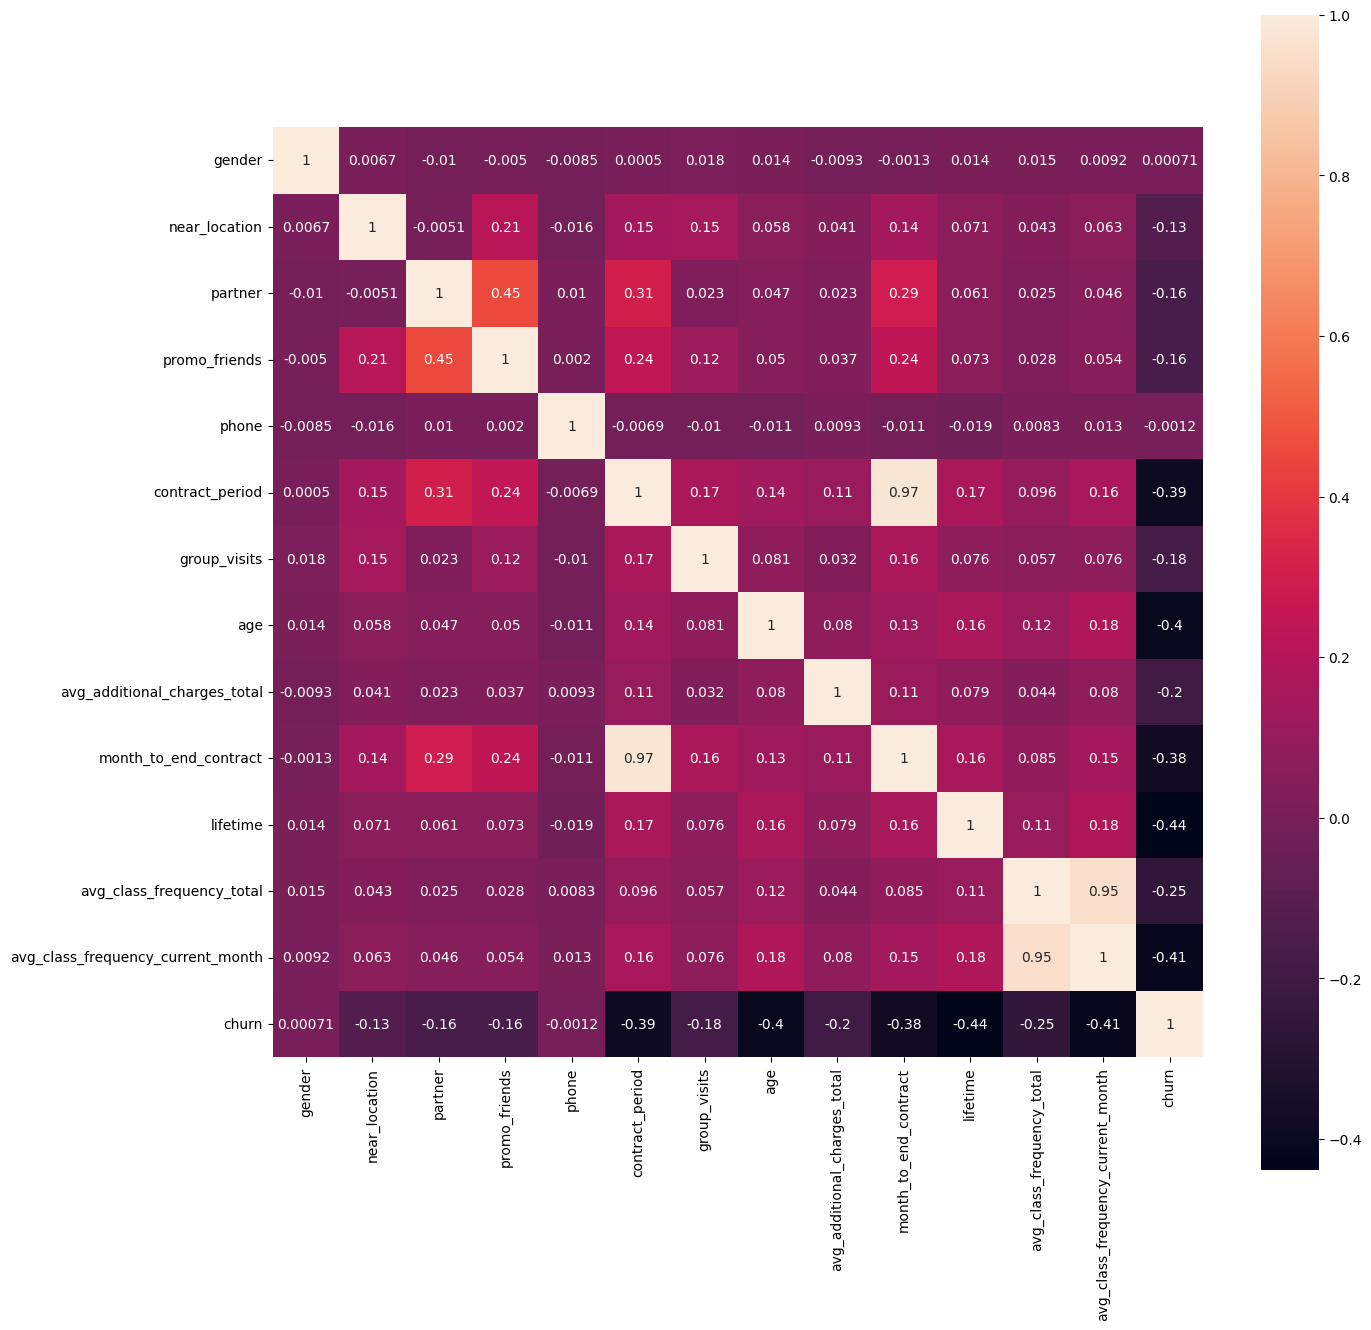

In [23]:
#buildig and rendering a correlation matrix
gym_churn_cm = gym_churn.corr()

#ploting a heatmap for the correlation matrix
plt.figure(figsize=[15,15])
sns.heatmap(gym_churn_cm, annot=True, square=True)

plt.show()

#make diagrams of the characteristic-objective variable paired distribution for each characteristic

for col in gym_churn.drop(['churn','near_location','phone','group_visits'], axis=1).columns:
    sns.scatterplot(x=gym_churn[col], y=gym_churn['churn'])
    plt.show()

Conclusion
- When analysing the correlation it is possible to see that none of the variables have a strong positive correlation with the churn.
- After comparing the paired distribution for each characteristic with the churn 

    Ainda tenho coisas para fazer aqui...

## Step 3 - build a model to predict customer churn

In [24]:
#dividing the dataset

X = gym_churn.drop(columns=['churn'])
y = gym_churn['churn']

#dividing the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [25]:
#training the StandardScaler with the training set 

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [26]:
#transforming the training and test sets

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [27]:
#defining the function do determine accuracy, precision, recall
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metric'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

### 3.1 training the model with logistic regression

In [28]:
#defining the model

lr_model = LogisticRegression(random_state=0)

#training the model
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [29]:
#using the model to make predictions

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

#printing all metrics
print_all_metrics(y_test, lr_predictions,lr_probabilities, title= 'Metrics for the logistic regression')

Metrics for the logistic regression
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


### 3.2 training the model with random forest

In [30]:
#defining the forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

#training the model
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [31]:
#using the forest model to make predictions
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

#printing all metrics

print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for the random forest')

Metrics for the random forest
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


### 3.3 evaluating accuracy, precision and recall

- According to the results obtained from the logistic regression we obtained the following results:
    - Accuracy: 0.92
	- Precision: 0.85
	- Recall: 0.83

- As for the random forest predictions we obtained the following results:
    - Accuracy: 0.92
	- Precision: 0.84
	- Recall: 0.81

- This means that the logistic regression had better results than the random forest model to validate the data.

## Step 4 - Create customer groupings

In [32]:
#creating a StandardScaler object and applying it to train set
sc = StandardScaler()

#training the scaler and transforming the matrix for a train set
X_train_st = sc.fit_transform(X_train)

linked = linkage(X_train_st, method='ward')

#### 4.1 Dendrogram

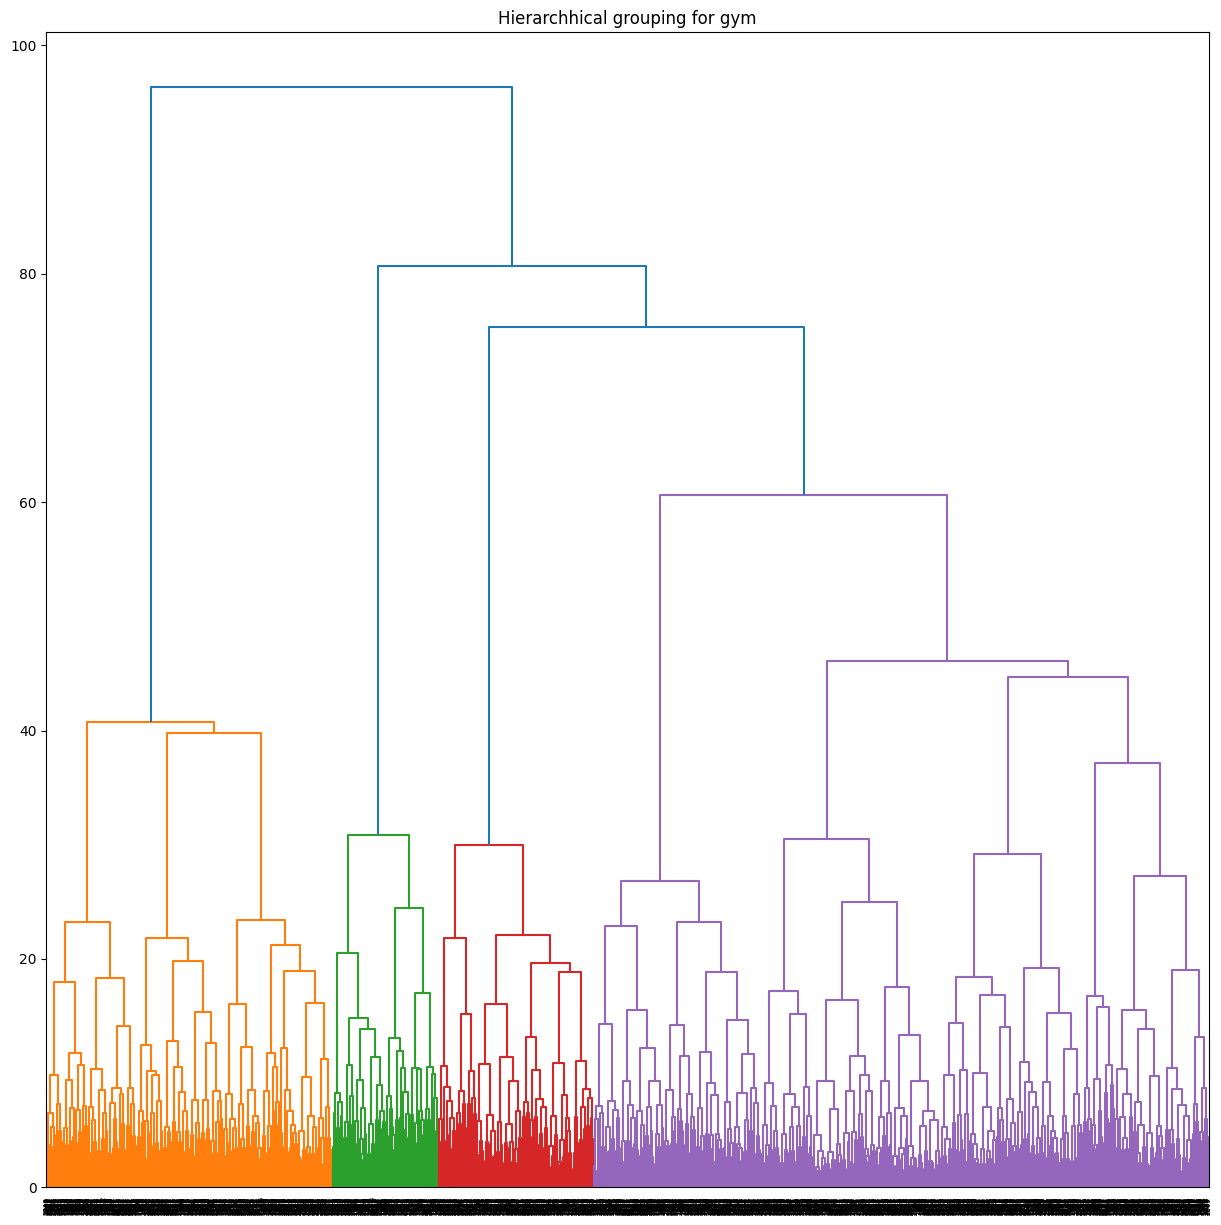

In [41]:
#ploting the dendrogram

plt.figure(figsize=[15,15])
dendrogram(linked, orientation='top')
plt.title('Hierarchhical grouping for gym')
plt.show()

- Based on the 5 colors from the dendrogram I'm going to use a model with 5 clusters in the following steps.

#### 4.2 Training the group with K-means

In [34]:
#set the function to render paired feature graphs for groupings
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=[10,10])
    sns.scatterplot(x=x_name, y=y_name, hue=cluster_name, data=df, palette='Paired')
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [35]:
#standardizing the data
sc = StandardScaler()
X_sc = sc.fit_transform(gym_churn)

In [36]:
#seting the k-means model with 5 clusters
km = KMeans(n_clusters = 5)

#predict the clusters for observations
labels = km.fit_predict(X_sc)

In [37]:
#storing the grouping labels in our dataframe
gym_churn['churn_rate'] = labels

In [38]:
#obtaining the statistics of mean values of the charcteristics per cluster
gym_churn.groupby(['churn_rate']).mean() #aqui vai o mesmo nome da coluna colocado anteriormente

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
churn_rate,,,,,,,,,,,,,,
0,0.578059,0.924051,0.362869,0.210970,0.805907,4.181435,0.485232,29.814346,156.907560,3.734177,13.801688,2.035413,2.047609,0.000000
1,0.512452,0.760536,0.340996,0.173372,0.905172,1.551724,0.260536,26.887931,113.387280,1.503831,1.008621,1.425968,1.000757,0.979885
2,0.498449,0.863495,0.000000,0.104447,0.910031,2.390900,0.453981,30.207859,159.312286,2.260600,3.579111,2.092530,2.094599,0.008273
3,0.501188,0.811164,0.997625,0.534442,0.920428,3.422803,0.387173,29.967933,152.594043,3.175772,3.856295,2.005211,2.001823,0.015439
4,0.510989,0.934066,0.730769,0.496703,0.904396,12.000000,0.546154,29.841758,164.475092,10.962637,4.249451,2.014408,2.007826,0.018681


    utilizar os nomes das colunas de média aqui...
    

In [39]:
print(gym_churn.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn', 'churn_rate'],
      dtype='object')


In [ ]:
#render the graphic for the paired characteristics
show_clusters_on_plot(gym_churn,'avg_class_frequency_total','avg_class_frequency_current_month','churn_rate')

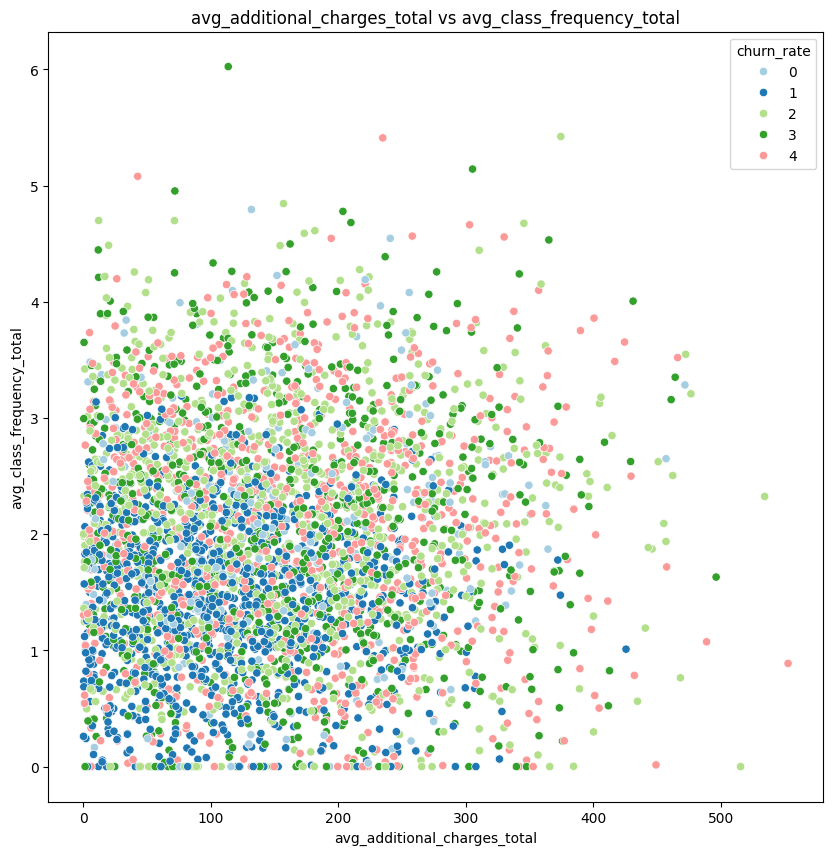

In [43]:
#render the graphic for the paired characteristics
show_clusters_on_plot(gym_churn,'avg_additional_charges_total','avg_class_frequency_total','churn_rate')

## Step 5 - Draw conclusions and make basic recommendations about working with clients